In [1]:
import sys
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import numpy as np
import datetime as dt
import geopandas as gpd
import dendropy
import csv
from shapely.geometry import Point
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from pyproj import Proj,transform
import tqdm
import pandas as pd
from matplotlib import cm
import matplotlib
import matplotlib.ticker as plticker
from math import radians, cos, sin, asin, sqrt
import os
import seaborn as sns
csv.field_size_limit(sys.maxsize)

import scipy 

In [2]:
uk_map = gpd.read_file("../../Data/UK_geog_data/UK_map.json")
uk_map = uk_map.to_crs("EPSG:3395")
england = uk_map.loc[uk_map["NAME_1"] == "England"]

utla_map = gpd.read_file("../../Data/UK_geog_data/UTLA_administrative_areas.json")
utla_map = utla_map.to_crs("EPSG:3395")
england_utla = utla_map.loc[utla_map['CODE'].str.startswith("E")]

pc_map = gpd.read_file("../../Data/UK_geog_data/England_postcode_districts.json")
pc_map.crs = "epsg:27700"
pc_map = pc_map.to_crs("epsg:3395")

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3395')

def true_date(date):
    
    year = str(date).split(".")[0]
    decimal = f'0.{str(date).split(".")[1]}'
    
    if year == '2020':
        day_no = float(decimal) * 366
    else:
        day_no = float(decimal) * 365
        
    delta = dt.timedelta(day_no)
    
    start = dt.date(year=int(year), month=1, day=1)
    tr_date = start + delta
    
    return str(tr_date)

def decimal_date(date):
    
    if type(date) == str:
        date = dt.datetime.strptime(date,"%Y-%m-%d").date()
    year = date.year
    if year == 2020:
        div = 366
    else:
        div = 365
    start = dt.date(year=year, month=1, day=1)
    decimal = (date - start).days/div
    
    dec_date = year + decimal
    return dec_date

/usr/local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

In [3]:
colours = {
"0_67":"#e2ecf2",
"0_92":"#ffd544",
"0_190":"#fe6362",
"0_322":"#484c7e",
"0_386":"#bbbee9",
"1_51": "#98c1d9",
"2_337": "#293241"  
}

names = {
"0_67":"Lineage IV",
"0_92":"Lineage I",
"0_190":"Lineage II",
"0_322":"Lineage VI",
"0_386":"Lineage VII",
"1_51": "Lineage V",
"2_337": "Lineage III" 
}

colours_renamed = {
"Lineage I":"#ffd544",
"Lineage II":"#fe6362",
"Lineage III":"#293241",
"Lineage V":"#98c1d9",
"Lineage IV":"#e2ecf2",
"Lineage VI":"#484c7e",
"Lineage VII":"#bbbee9"
}

large_lins = list(colours.keys())

In [4]:
def pull_from_existing_file(results_file):
    edge_dict = defaultdict(dict)
    with open(results_file) as f:
        count = 0
        data = csv.DictReader(f)
        for l in data:
            count += 1
            edge_dict[count] = {}
            edge_dict[count]["start_lat"] = float(l['start_lat_3395'])
            edge_dict[count]["start_long"] = float(l['start_long_3395'])
            edge_dict[count]["end_lat"] = float(l['end_lat_3395'])
            edge_dict[count]['end_long'] = float(l['end_long_3395'])
            edge_dict[count]["start_dec_date"] = float(l['start_dec_date'])
            edge_dict[count]["end_dec_date"] = float(l['end_dec_date'])
            edge_dict[count]["start_real_date"] = l['start_real_date']
            edge_dict[count]["end_real_date"] = l['end_real_date']
            edge_dict[count]["start_pc"] = l['start_pc']
            edge_dict[count]["end_pc"] = l['end_pc']
            edge_dict[count]["start_utla"] = l['start_utla']
            edge_dict[count]["end_utla"] = l['end_utla']
            edge_dict[count]["length"] = l['length']
            
    edge_dict_sorted = {k:v for k,v in sorted(edge_dict.items(), key=lambda item: item[1]["end_dec_date"],reverse=True)}
            
    return edge_dict_sorted

In [5]:
edge_dict_0_67 = pull_from_existing_file("../results/MCC_files_all/0_67_mcc_data.csv")
edge_dict_0_92 = pull_from_existing_file("../results/MCC_files_all/0_92_mcc_data.csv")
edge_dict_0_190 = pull_from_existing_file("../results/MCC_files_all/0_190_mcc_data.csv")
edge_dict_0_322 = pull_from_existing_file("../results/MCC_files_all/0_322_mcc_data.csv")
edge_dict_0_386 = pull_from_existing_file("../results/MCC_files_all/0_386_mcc_data.csv")
edge_dict_1_51 = pull_from_existing_file("../results/MCC_files_all/1_51_mcc_data.csv")
edge_dict_2_337 = pull_from_existing_file("../results/MCC_files_all/2_337_mcc_data.csv")

large_lin_dicts = [edge_dict_0_67, edge_dict_0_92, edge_dict_0_190, edge_dict_0_322, edge_dict_0_386, edge_dict_1_51, edge_dict_2_337]


In [26]:
lin_dicts = defaultdict(dict)
for file in os.listdir("../results/MCC_files_all/"):
    if file.endswith(".csv"):
        new_dict = {}
        new_dict = pull_from_existing_file(f'../results/MCC_files_all/{file}')
        name = "_".join(file.strip(".csv").split("_")[0:2])
#         if name not in large_lins:
        lin_dicts[name] = new_dict

In [27]:
print(len(lin_dicts))

266


## Plot five largest lineages on map

Direction is anti-clockwise

In [72]:
dates = []
for edge, edgedict in edge_dict_0_67.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])
for edge, edgedict in edge_dict_0_92.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])
for edge, edgedict in edge_dict_0_190.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])
for edge, edgedict in edge_dict_0_322.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])
for edge, edgedict in edge_dict_0_386.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])
for edge, edgedict in edge_dict_1_51.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])
for edge, edgedict in edge_dict_2_337.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])
    
norm = matplotlib.colors.Normalize(vmin=min(dates), vmax=max(dates))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#484C7E","#FE6362", "#FFD544"])
colour_dict = {}
for date in dates:
    colour_dict[date] = cmap(norm(date))

In [77]:
def make_plot(edge_dict, lineage_name, colour_dict):
    
        
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    matplotlib.rcParams.update({'font.size': 8})
    england["geometry"] = england.geometry.simplify(1000)

    england.plot(ax=ax, color="whitesmoke", edgecolor="lightgrey")

    count = 0
    
    for edge, edgedict in tqdm.tqdm(edge_dict.items()):
        
        count += 1
        
        point_dict = defaultdict(list)

        A = edgedict["start_long"],edgedict["start_lat"]
        B = edgedict["end_long"],edgedict["end_lat"]
        start_date = edgedict["start_dec_date"]
        end_date = edgedict["end_dec_date"]

        kw = dict(color="slategrey",linewidth=0.3)

        liney = mpatches.FancyArrowPatch(A, B, arrowstyle="-",
                                 connectionstyle="arc3,rad=.5", **kw)

        ax.add_patch(liney)

        ax.scatter(A[0], A[1], s=3, color=colour_dict[start_date], alpha=1.0, zorder=5)
        ax.scatter(B[0], B[1], s=3, color=colour_dict[end_date], alpha=1.0, zorder=6)

    if lineage_name == "Lineage VII":

        bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
        new_ticks = []

        for i in bar.get_ticks():
            new_ticks.append(true_date(i))
        bar.set_ticks(bar.get_ticks())
        bar.set_ticklabels(new_ticks)

    ax.axis('off')
#     plt.title(lineage_name)
    plt.savefig(f"../figures/{lineage_name}_geographical_spread.eps", bbox_inches='tight')
    plt.savefig(f"../figures/{lineage_name}_geographical_spread.pdf", bbox_inches='tight')

#     plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 3038/3038 [02:52<00:00, 17.59it/s]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 3358/3358 [03:44<00:00, 14.94it/s]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

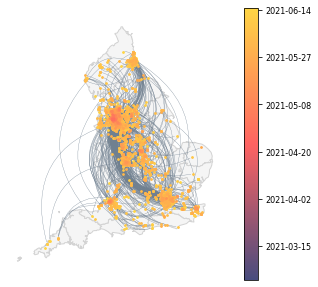

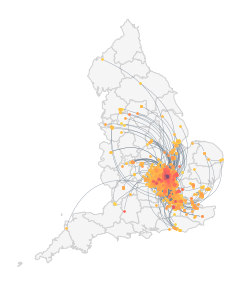

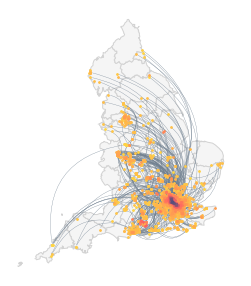

In [78]:
make_plot(edge_dict_0_67, names["0_67"], colour_dict)
make_plot(edge_dict_0_92, names["0_92"], colour_dict)
make_plot(edge_dict_0_190, names["0_190"], colour_dict)
make_plot(edge_dict_0_322, names["0_322"], colour_dict)
make_plot(edge_dict_0_386, names["0_386"], colour_dict)
make_plot(edge_dict_1_51, names["1_51"], colour_dict)
make_plot(edge_dict_2_337, names["2_337"], colour_dict)

## Plot against movements

In [7]:
date_to_normalised_mvmt = {}
with open("../../Data/uk_movement.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        date = dt.datetime.strptime(l['date'], "%Y-%m-%d").date()
        date_to_normalised_mvmt[date] = float(l["movement_normalised"])
person_movements = {k:v for k,v in sorted(date_to_normalised_mvmt.items())}

In [28]:
virus_movements = {}
between_pc_mvmts = {}
for edgedict in tqdm.tqdm(lin_dicts.values()):
    for i, edge in edgedict.items():
            
        date = dt.datetime.strptime(edge['start_real_date'], "%Y-%m-%d").date()
        
        if date not in virus_movements:
            virus_movements[date] = 1
        else:
            virus_movements[date] += 1
        
        if edge["start_pc"] != edge["end_pc"]:
            if date not in between_pc_mvmts:
                between_pc_mvmts[date] = 1
            else:
                between_pc_mvmts[date] += 1
                
first_date = min(virus_movements)
last_date = max(virus_movements)

day = dt.timedelta(1)
date = first_date
for i in range((last_date - first_date).days):
    new_date = date + day
    if new_date not in virus_movements:
        virus_movements[new_date] = 0
    if new_date not in between_pc_mvmts:
        between_pc_mvmts[new_date] = 0
    date = new_date
    
virus_movement_ordered = {k:v for k,v in sorted(virus_movements.items())}
between_pc_movement_ordered = {k:v for k,v in sorted(between_pc_mvmts.items())}

100%|██████████| 266/266 [00:01<00:00, 199.09it/s]


In [29]:
df_dict = defaultdict(list)
for k,v in virus_movement_ordered.items():
    df_dict["Date"].append(k)
    df_dict["Movements"].append(v)
    df_dict["Between_PC"].append(between_pc_movement_ordered[k])
    
df = pd.DataFrame(df_dict)
df['7 day rolling'] = df.Movements.rolling(7).mean()
df['7 day rolling between pc'] = df.Between_PC.rolling(7).mean()


In [32]:
new_last_date = dt.date(2021,6,1)
first_mvmt = dt.date(2021,1,1)

relevant_person_movements = {}
for k,v in person_movements.items():
    if k >= first_mvmt:
        relevant_person_movements[k] = v
        
relevant_person_movements2 = {}
for k,v in person_movements.items():
    if k >= first_date and k <= new_last_date:
        relevant_person_movements2[k] = v


relevant_virus_movements = {}
for k,v in zip(df["Date"], df["7 day rolling"]):
    if k >= first_date and k <= new_last_date:
        relevant_virus_movements[k] = v
        
relevant_pc_movements = {}
for k,v in zip(df["Date"], df["7 day rolling between pc"]):
    if k >= first_date and k <= new_last_date:
        relevant_pc_movements[k] = v
        
#removed last week for sampling lag

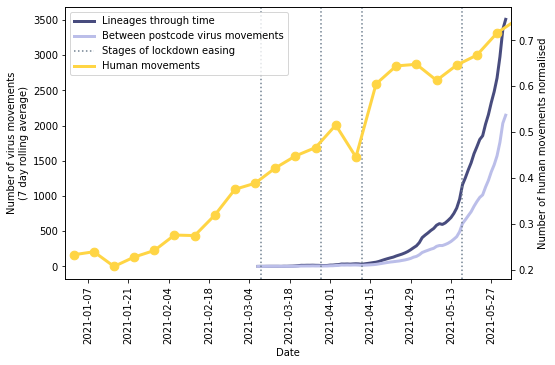

In [79]:
matplotlib.rcParams.update({'font.size': 10})
loc = plticker.MultipleLocator(base=14.0)

key_dates = [dt.date(2021,3,8), dt.date(2021,3,29), dt.date(2021,4,12), dt.date(2021,5,17)]

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax2 = ax.twinx()

line1 = ax.plot(relevant_virus_movements.keys(),relevant_virus_movements.values(), color="#484c7e", linewidth=3,label="Lineages through time")
line2 = ax2.plot(relevant_person_movements.keys(), relevant_person_movements.values(), color="#ffd544",linewidth=3, label="Human movements")
ax2.scatter(relevant_person_movements.keys(), relevant_person_movements.values(), s=75, color="#ffd544")

line3 = ax.plot(relevant_pc_movements.keys(), relevant_pc_movements.values(), color="#bbbee9", linewidth=3, label="Between postcode virus movements")


for date in key_dates[1:]:
    ax.axvline(date, color="slategrey", linestyle="dotted")

ax.axvline(dt.date(2021,3,8), color="slategrey", linestyle="dotted", label="Stages of lockdown easing")

ax.set_ylabel("Number of virus movements\n(7 day rolling average)")
ax2.set_ylabel("Number of human movements normalised")
ax.set_xlabel("Date")

ax.set_xlim(first_mvmt-dt.timedelta(2),new_last_date+dt.timedelta(2))

ax.tick_params(axis='x', labelrotation = 90)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.xaxis.set_major_locator(loc)

plt.savefig("../figures/human_and_virus_movements.pdf", bbox_inches='tight')

plt.show()

In [34]:
fracs = {}
for date,between, all_mv in zip(df["Date"],df["7 day rolling between pc"], df["7 day rolling"]):
    if date >= first_date and date <= new_last_date:
        if all_mv != 0:
            fracs[date] = between/all_mv
    

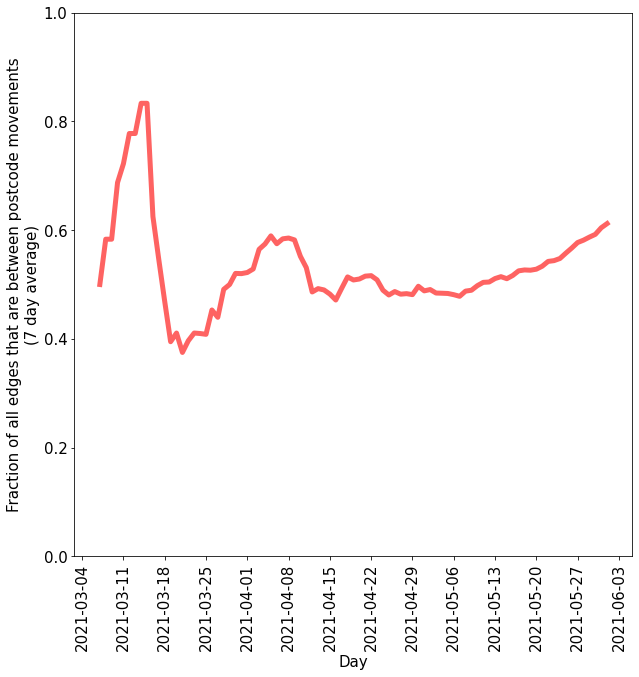

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
loc = plticker.MultipleLocator(base=7.0)

plt.plot(fracs.keys(), fracs.values(), linewidth=5, color="#fe6362")

plt.xlabel("Day")
plt.ylabel("Fraction of all edges that are between postcode movements\n(7 day average)")
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', labelrotation = 90)

plt.ylim(0,1)
# plt.savefig("../")

plt.show()

## Source sink bits


In [36]:
all_utlas = set()
for edgedict in lin_dicts.values():
    for i, edge in edgedict.items():
        all_utlas.add(edge['start_utla'])
        all_utlas.add(edge['end_utla'])

In [37]:
london = "GREATER_LONDON_AUTHORITY"
manchester_lst = ["SALFORD_DISTRICT_(B)","'TRAFFORD_DISTRICT_(B)", "STOCKPORT_DISTRICT_(B)", "OLDHAM_DISTRICT_(B)", "BOLTON_DISTRICT_(B)",
     "TAMESIDE_DISTRICT_(B)", "BURY_DISTRICT_(B)", "ROCHDALE_DISTRICT_(B)", "WIGAN_DISTRICT_(B)", "MANCHESTER_DISTRICT_(B)"]
manchester = set()
for i in manchester_lst:
    manchester.add(i)


In [38]:
out_of_london = 0
out_of_manc = 0

for edgedict in lin_dicts.values():
    for i, edge in edgedict.items():
        if edge["start_utla"] != edge["end_utla"]:
            if edge["start_utla"] in manchester and edge["end_utla"] not in manchester:
                out_of_manc += 1
            elif edge["start_utla"] == london:
                out_of_london += 1

print(out_of_manc)
print(out_of_london)
print(out_of_manc/out_of_london)

5206
1700
3.0623529411764707


In [40]:
out_of_manc = 0
in_manc = 0

# for edgedict in lin_dicts.values():
for i, edge in edgedict_0_92.items():
    if edge["start_utla"] in manchester and edge["end_utla"] not in manchester:
        out_of_manc += 1
    elif edge["start_utla"] in manchester and edge["end_utla"] in manchester:
        in_manc += 1

print(out_of_manc)
print(in_manc)

print(in_manc/out_of_manc)

5206
18476
3.548981943910872


## Distance of movements

In [49]:
lin_to_movements = defaultdict(list)
for file in os.listdir("../results/movements/"):
    if file.endswith(".csv"):
        name = "_".join(file.strip(".csv").split("_")[0:2])
        if name in large_lins:
            new_name = names[name]
            with open(os.path.join("../results/movements/", file)) as f:
                data = csv.DictReader(f)
                for l in tqdm.tqdm(data):
                      lin_to_movements[new_name].append(float(l['distance']))

4329it [00:00, 138125.44it/s]
1933it [00:00, 152275.22it/s]
2017it [00:00, 139565.65it/s]
2238it [00:00, 119653.95it/s]
13913it [00:00, 153939.00it/s]
1375it [00:00, 145642.91it/s]
3601it [00:00, 147813.08it/s]


In [54]:
names_list = ["Lineage I", "Lineage II", "Lineage III", "Lineage IV", "Lineage V", "Lineage VI", "Lineage VII"]

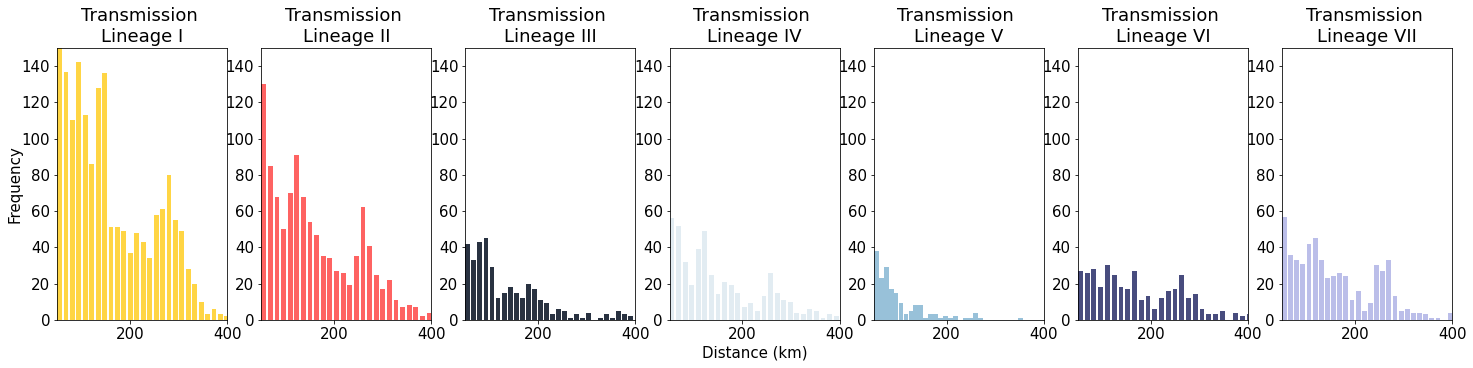

In [56]:
fig, ax = plt.subplots(1,7,figsize=(25,5))
matplotlib.rcParams.update({'font.size': 15})

count = 0
for lin in names_list:
#     if lin == "lineage I":
#         ylim_upper = 1000
#     else:
    ylim_upper = 150
    ax[count].hist([x for x in lin_to_movements[lin] if x>50], bins=30, width=10,color=colours_renamed[lin])
    ax[count].set_title(f'Transmission \n{lin}')
    ax[count].set_xlim(50,400)
    ax[count].set_ylim(0,ylim_upper)
    count += 1

fig.add_subplot(111,frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")

    
plt.savefig("../figures/viral_movement_histograms.pdf", bbox_inches="tight")
plt.savefig("../figures/viral_movement_histograms.png", bbox_inches="tight")

plt.show()

## Movements over time

In [58]:
date_to_movements = defaultdict(list)
for file in os.listdir("../results/movements/"):
    if file.endswith(".csv"):
        with open(os.path.join("../results/movements/",file)) as f:
            data = csv.DictReader(f)
            for l in tqdm.tqdm(data):
                date = dt.datetime.strptime(l['date'], "%Y-%m-%d").date()
                date_to_movements[date].append(float(l['distance']))

5it [00:00, 2121.34it/s]
5it [00:00, 8962.19it/s]
38it [00:00, 24389.22it/s]
16it [00:00, 14771.93it/s]
8it [00:00, 11748.75it/s]
16it [00:00, 17895.70it/s]
6it [00:00, 8732.07it/s]
8it [00:00, 11378.24it/s]
7it [00:00, 9256.03it/s]
18it [00:00, 16215.09it/s]
19it [00:00, 17418.97it/s]
39it [00:00, 22349.75it/s]
7it [00:00, 11129.69it/s]
143it [00:00, 33031.47it/s]
82it [00:00, 29539.89it/s]
44it [00:00, 25173.83it/s]
28it [00:00, 16261.49it/s]
25it [00:00, 19533.83it/s]
5it [00:00, 6417.23it/s]
30it [00:00, 18586.28it/s]
6it [00:00, 8264.64it/s]
18it [00:00, 19962.31it/s]
3it [00:00, 3900.47it/s]
4329it [00:00, 35987.09it/s]
41it [00:00, 11537.50it/s]
9it [00:00, 12180.94it/s]
12it [00:00, 13245.17it/s]
45it [00:00, 17730.74it/s]
9it [00:00, 9923.43it/s]
8it [00:00, 9198.04it/s]
21it [00:00, 16380.95it/s]
5it [00:00, 6069.90it/s]
12it [00:00, 13086.75it/s]
99it [00:00, 26005.89it/s]
35it [00:00, 20290.34it/s]
72it [00:00, 20385.44it/s]
12it [00:00, 8908.26it/s]
31it [00:00, 19872.14it

In [59]:
sorted_mvmts = {k:v for k,v in sorted(date_to_movements.items(), key=lambda item: item[0])}

In [60]:
month_mvmts = defaultdict(list)
all_month_mvmts = defaultdict(list)
for day, dists in sorted_mvmts.items():
    to_add = []
    for i in dists:
        if i >= 50:
            to_add.append(i)
    
    month_mvmts[day.month].extend(to_add)
    all_month_mvmts[day.month].extend(dists)
    

In [61]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

In [62]:
month_dict={12:"December", 1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June"}

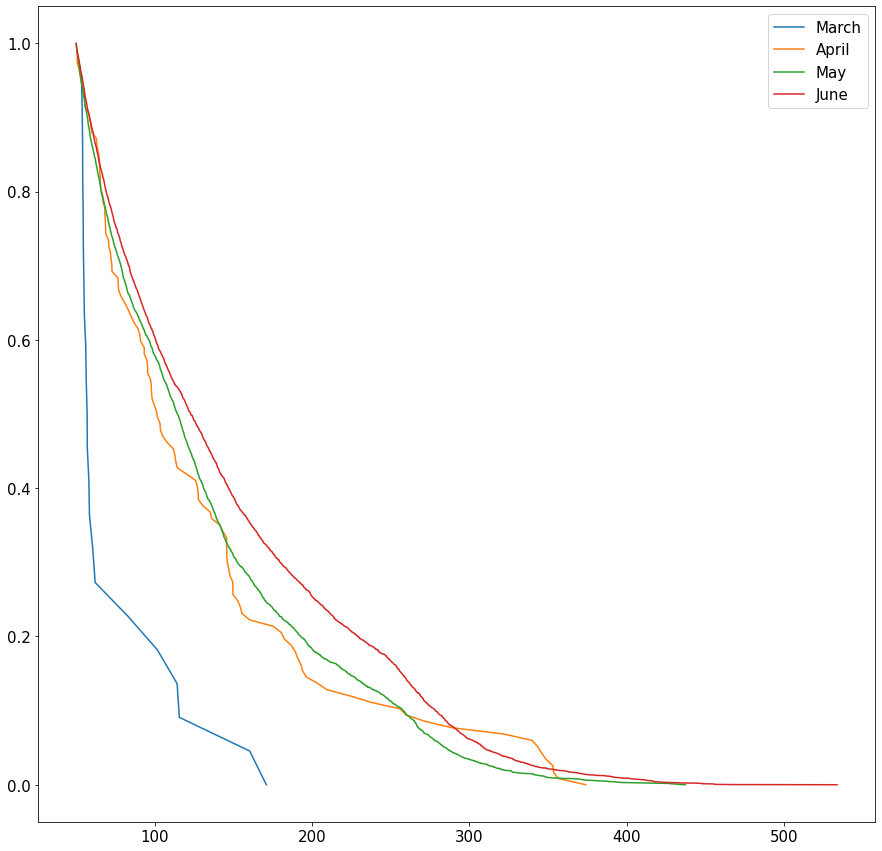

In [63]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

for month, data in month_mvmts.items():
    
    if month != 11:
                
        x,y = ecdf(data)

        reverse = []
        for i in y:
            reverse.append(1-i)

        ax.plot(x, reverse, label=month_dict[month])
        
ax.legend()

plt.show()

In [64]:
first_date = dt.date(2021,4,12)
second_date = dt.date(2021,5,17)

lockdown_mvmts = defaultdict(list)

for date, mvmts in sorted_mvmts.items():
#     if date < first_date:
#         lockdown_mvmts["Before"].extend(mvmts)
#     elif date >= first_date and date < second_date:
#         lockdown_mvmts["Between"].extend(mvmts)
#     else:
#         lockdown_mvmts["After"].extend(mvmts)
    if date < first_date:
        for i in mvmts:
            if i > 25:
                lockdown_mvmts["Before"].append(i)
    elif date >= first_date and date < second_date:
        for i in mvmts:
            if i > 25:
                lockdown_mvmts["Between"].append(i)
    elif date >= second_date:
        for i in mvmts:
            if i > 25:
                lockdown_mvmts["After"].append(i)
    else:
        print(date,mvmts)

    

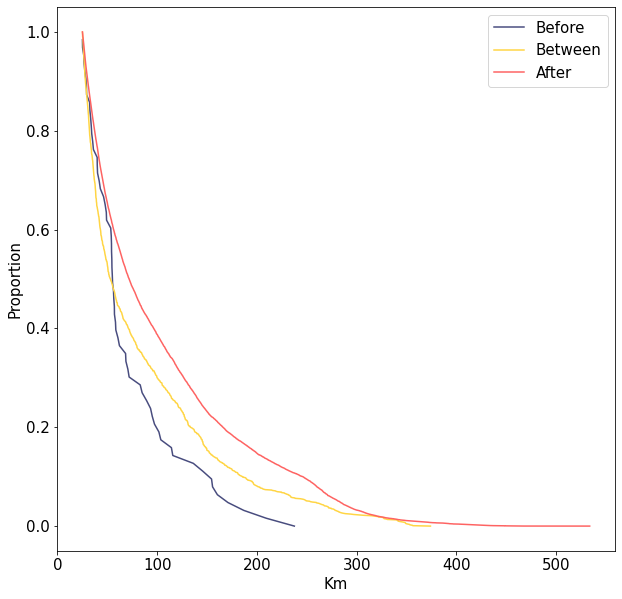

In [83]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
matplotlib.rcParams.update({'font.size': 15})

colours = {"Before":"#484c7e", "Between":"#ffd544", "After":"#fe6362"}

for period, data in lockdown_mvmts.items():
    
                
        x,y = ecdf(data)

        reverse = []
        for i in y:
            reverse.append(1-i)

        ax.plot(x, reverse, label=period, color=colours[period]) 
        
ax.legend()
ax.set_xlabel("Km")
ax.set_ylabel("Proportion")

plt.savefig("../figures/movement_length_over_time.pdf", bbox_inches='tight')
plt.savefig("../figures/movement_length_over_time.png", bbox_inches='tight')


plt.show()

In [66]:
props = {}
for month, dists in all_month_mvmts.items():
    below = 0
    above = 0
    for i in dists:
        if i < 50:
            below += 1
        else:
            above += 1
    props[month] = above/below

In [67]:
props

{3: 0.20952380952380953,
 4: 0.07090909090909091,
 5: 0.16294661107023137,
 6: 0.3345779339629548}